Песчинский Иван Викторович


@IF_BBESCH

# Описание проекта

Предположим, что оформление музыкального альбома как-то связано с его содержанием. Но насколько сильна эта связь?

Наша задача - разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

## 1. Импорты

In [1]:
import pandas as pd
import numpy as np
import os
import ntpath
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn

from PIL import Image
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from math import ceil

In [2]:
path = '/Users/ivanpeschinsky/Documents/New/studing/masterskaya_cv/data/'

## 2. Загрузка данных

Напишем функцию, которая загрузит изображения из папок

In [3]:
def image_opener(folder_name):
    
    directory = path + folder_name
    
    images = []
    images_names = []

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            images.append(Image.open(f).convert('RGB'))
            images_names.append((ntpath.basename(f)))
    
    return images, images_names

Возможно, это не оптимальное решение открыть папки таким образом, но оставим его как есть)

In [4]:
%%time

anime_images, anime_images_names = image_opener('anime')
black_metal_images, black_metal_images_names = image_opener('black metal')
classical_images, classical_images_names = image_opener('classical')
country_images, country_images_names = image_opener('country')
disco_images, disco_images_names = image_opener('disco')
edm_images, edm_images_names = image_opener('edm')
jazz_images, jazz_images_names = image_opener('jazz')
pop_images, pop_images_names = image_opener('pop')
rap_images, rap_images_names = image_opener('rap')
reggae_images, reggae_images_names = image_opener('reggae')

CPU times: user 1min 14s, sys: 5.99 s, total: 1min 20s
Wall time: 1min 46s


Изображения не равномерно распределены под жанрам. В целом количество жанров у нас ограничено. Посмотрим, что из этого выйдет.

In [5]:
print('anime len: ', len(anime_images))
print('black metal len: ', len(black_metal_images))
print('classical len: ', len(classical_images))
print('country len: ', len(country_images))
print('disco len: ', len(disco_images))
print('edm len: ', len(edm_images))
print('jazz len: ', len(jazz_images))
print('pop len: ', len(pop_images))
print('rap len: ', len(rap_images))
print('reggae len: ', len(reggae_images))

anime len:  1189
black metal len:  450
classical len:  955
country len:  1486
disco len:  468
edm len:  719
jazz len:  821
pop len:  803
rap len:  328
reggae len:  581


Посмотрим, как выглядит типичная музыкальная обложка для каждого жанра

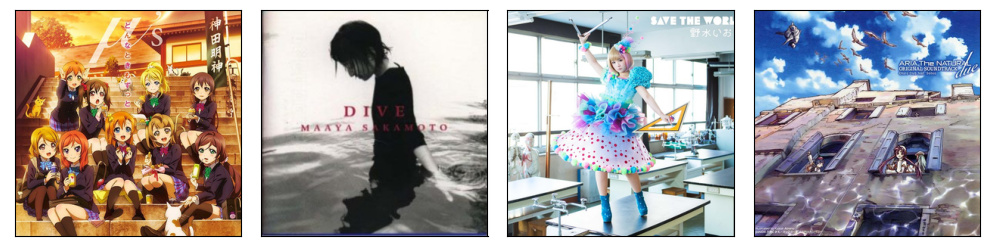

In [6]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(anime_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

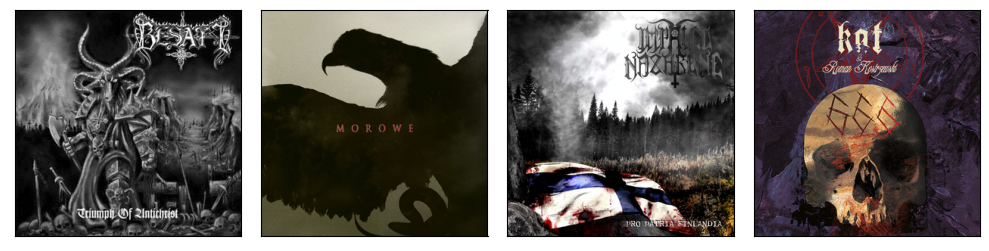

In [7]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(black_metal_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

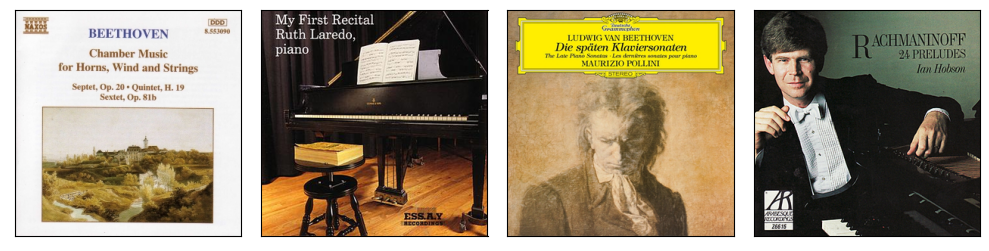

In [8]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(classical_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

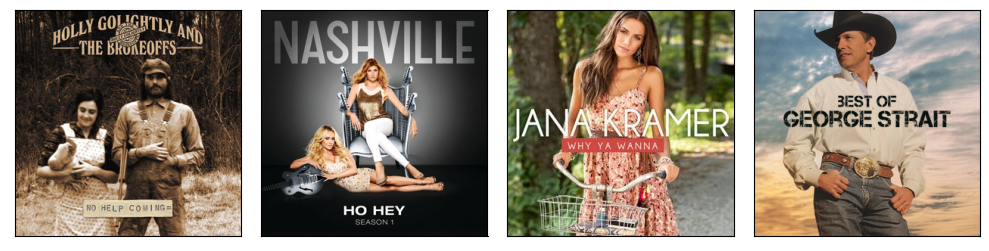

In [9]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(country_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

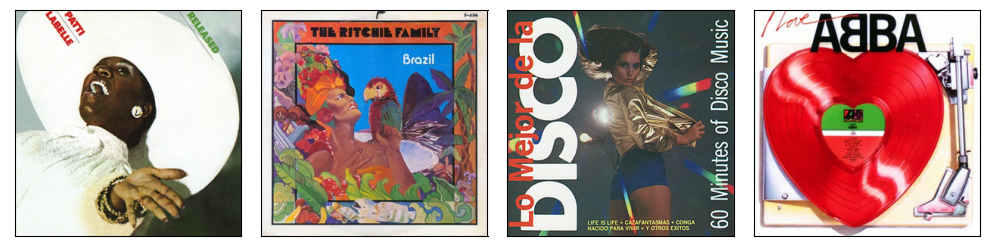

In [10]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(disco_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

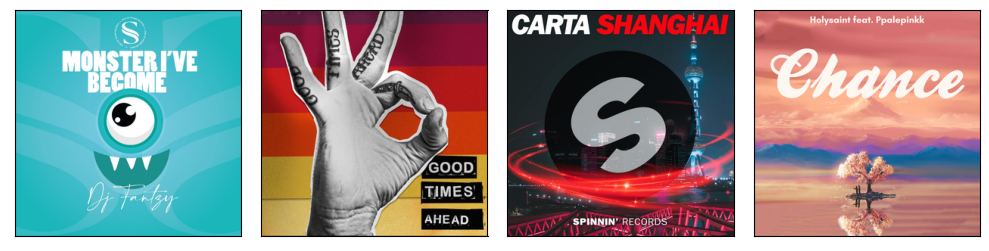

In [11]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(edm_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

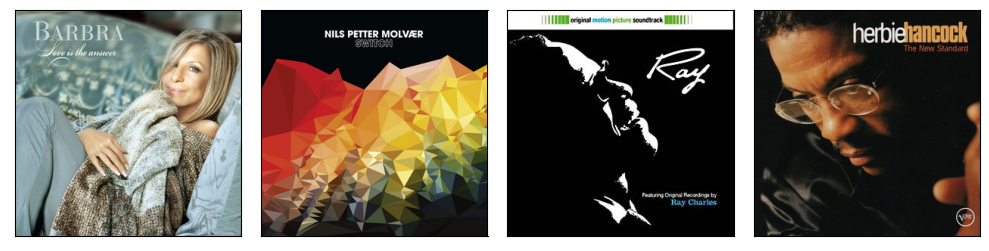

In [12]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(jazz_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

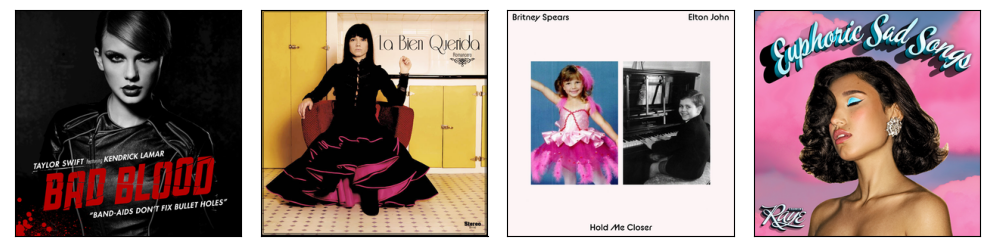

In [13]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(pop_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

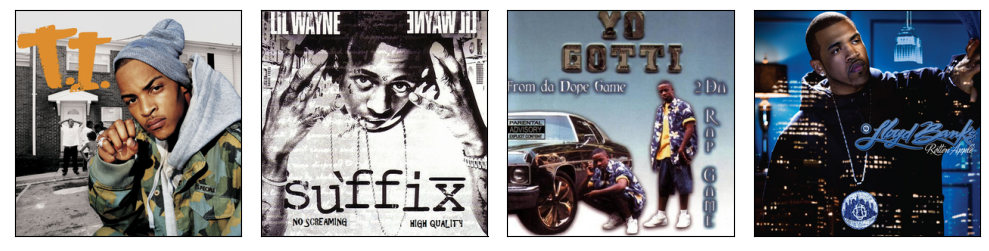

In [14]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(rap_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

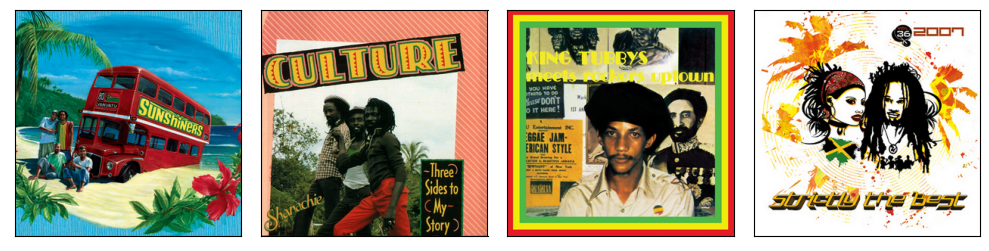

In [15]:
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(reggae_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## 3. Подготовка данных

Векторизацию изображений выполним с помошью инструментов pytorch

In [16]:
# загрузим предтренированную модель
resnet = models.resnet50(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# заморозим веса
for param in resnet.parameters():
    param.requires_grad_(False)

In [18]:
# получим списки слоев и возьмем все слои кроме последнего
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
# переведем модель в режим предсказания
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [19]:
# приведем изображение к нужному формату
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.Resize(256), 
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor(), 
                                 norm])

In [20]:
# напишем функцию, с помощью которой получем эмбеддинги для изображений из каждой папки
def make_tensor(images):
    
    images_tensor = []
    
    for image in images:
        image_tensor = preprocess(image).unsqueeze(0)
        output_tensor = resnet(image_tensor).flatten()
        images_tensor.append(output_tensor)
        
    data_images = pd.DataFrame(images_tensor).astype('float')
    
    return data_images

In [21]:
%%time

data_anime = make_tensor(anime_images)
data_black_metal = make_tensor(black_metal_images)
data_classical = make_tensor(classical_images)
data_country = make_tensor(country_images)
data_disco = make_tensor(disco_images)
data_edm = make_tensor(edm_images)
data_jazz = make_tensor(jazz_images)
data_pop = make_tensor(pop_images)
data_rap = make_tensor(rap_images)
data_reggae = make_tensor(reggae_images)

CPU times: user 47min 39s, sys: 6min 39s, total: 54min 18s
Wall time: 31min 32s


## 4. Обработка данных

Самое простое, что можно сделать в плане обработки данных - это удалить дубликаты. Также добавим в данные целевую переменную, которая будет равна названию папки/жанра

In [22]:
def data_preprocessing(data, target):
    data = data.drop_duplicates()
    data.insert(loc=0, column='target', value=target)
    
    return data

In [23]:
%%time

data_anime = data_preprocessing(data_anime, 'anime')
data_black_metal = data_preprocessing(data_black_metal, 'black_metal')
data_classical = data_preprocessing(data_classical, 'classical')
data_country = data_preprocessing(data_country, 'country')
data_disco = data_preprocessing(data_disco, 'disco')
data_edm = data_preprocessing(data_edm, 'edm')
data_jazz = data_preprocessing(data_jazz, 'jazz')
data_pop = data_preprocessing(data_pop, 'pop')
data_rap = data_preprocessing(data_rap, 'rap')
data_reggae = data_preprocessing(data_reggae, 'reggae')

CPU times: user 3.94 s, sys: 349 ms, total: 4.29 s
Wall time: 4.44 s


In [24]:
data_anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 0 to 1188
Columns: 2049 entries, target to 2047
dtypes: float64(2048), object(1)
memory usage: 18.5+ MB


In [25]:
data_anime.head()

target         0         1         2         3         4         5  \
0  anime  0.238696  0.620842  0.362777  0.239072  1.077578  0.307301   
1  anime  0.028094  1.397246  0.639013  0.394546  0.863369  0.652764   
2  anime  0.135615  0.051869  0.316707  0.278676  1.273730  0.380631   
3  anime  0.264017  0.632499  0.070784  1.228567  0.254518  0.053442   
4  anime  0.248354  0.744300  0.934337  0.163681  0.249162  0.147381   

          6         7         8  ...      2038      2039      2040      2041  \
0  0.205467  0.029187  0.611996  ...  1.014887  0.089978  0.190843  0.203615   
1  0.120372  0.173793  0.559540  ...  0.006606  0.254885  0.490303  0.117230   
2  0.612440  0.216136  0.058890  ...  0.382352  0.430210  0.606244  0.130675   
3  0.196249  0.240082  0.150279  ...  0.302009  0.141568  0.452834  0.699468   
4  0.381576  1.097641  0.811609  ...  1.245814  0.946121  0.375833  0.379291   

       2042      2043      2044      2045      2046      2047  
0  0.079501  0.525872  0.284392  0.750699  0.278732  0.121305  
1  0.398345  0.039124  0.484847  0.040500  0.129547  0.089669  
2  0.202827  0.173256  0.151940  0.259896  0.239760  0.278381  
3  0.251293  0.394701  0.266677  0.429359  0.236689  0.124365  
4  0.534696  0.495534  0.393530  0.368811  0.119144  0.209180  

[5 rows x 2049 columns]

Соединим все обработанные изображения в один датасет

In [26]:
data = pd.concat([data_anime, data_black_metal, data_classical, 
                  data_country, data_disco, data_edm, data_jazz, 
                  data_pop, data_rap, data_reggae], 
                 ignore_index=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760 entries, 0 to 7759
Columns: 2049 entries, target to 2047
dtypes: float64(2048), object(1)
memory usage: 121.3+ MB


In [28]:
data.duplicated().sum()

0

Перемешаем данные и сбросим индекс

In [29]:
data = data.sample(frac=1).reset_index(drop=True)

In [30]:
data.head(10)

target         0         1         2         3         4         5  \
0  country  0.218554  2.036910  0.105730  0.083157  1.031279  0.562015   
1      edm  0.012319  1.449301  0.126496  0.162315  1.068116  0.216455   
2    anime  0.012996  0.735209  0.127022  0.027051  0.818442  0.039880   
3   reggae  0.279355  1.834000  0.017614  0.002854  0.592157  0.174169   
4  country  0.093825  3.548846  0.344593  0.234301  0.714955  0.184391   
5      pop  0.076523  1.616894  1.346861  0.338339  1.503664  0.328394   
6    disco  0.092750  0.316693  0.494683  0.198016  0.795381  0.153203   
7     jazz  0.314652  2.139764  0.506184  0.339570  0.229257  0.031223   
8    anime  0.558167  0.424189  3.638825  0.021867  0.610613  0.200924   
9      pop  0.375541  0.150455  1.612407  0.003350  0.504760  0.604560   

          6         7         8  ...      2038      2039      2040      2041  \
0  0.167717  0.001323  0.643098  ...  2.214940  0.419304  1.497090  0.021538   
1  0.067184  0.021192  0.075794  ...  0.853767  0.272678  0.245827  0.334027   
2  0.278304  0.133026  0.275303  ...  0.931304  0.464100  0.283929  0.014750   
3  0.194242  0.135202  0.294308  ...  1.673467  0.293726  0.228011  0.101630   
4  0.582733  0.030964  0.090546  ...  0.955674  0.038404  0.158017  0.101971   
5  0.021883  0.049535  0.027204  ...  0.755310  0.153414  1.898579  0.508785   
6  0.438434  0.101849  0.369727  ...  0.536427  0.419464  0.878681  0.187059   
7  0.718952  0.159049  0.485054  ...  0.922387  0.384262  0.637181  0.902482   
8  0.621766  0.061454  0.548230  ...  0.115665  0.148797  0.677650  0.554021   
9  1.360111  0.191766  0.257143  ...  0.041537  0.289868  0.203763  0.042546   

       2042      2043      2044      2045      2046      2047  
0  0.006112  0.024556  0.273917  0.015419  0.050567  0.192837  
1  0.191551  0.282479  0.255919  0.086660  0.506975  0.214127  
2  0.098244  0.265501  0.370176  0.154542  0.036282  0.029590  
3  0.040264  0.243584  0.402842  0.286173  0.689616  0.126782  
4  0.206258  0.262988  0.808640  0.198452  0.195218  0.059190  
5  0.474328  0.178696  0.403632  0.314266  0.228519  0.103636  
6  0.712519  0.183951  0.425603  0.212129  0.537453  0.127004  
7  0.222499  0.295019  0.334463  0.384668  0.418098  0.338615  
8  0.530991  0.257478  0.343234  0.103557  0.450360  0.123768  
9  1.698533  0.057108  0.154394  0.101507  0.325891  0.354870  

[10 rows x 2049 columns]

In [31]:
data.describe()

0            1            2            3            4     \
count  7760.000000  7760.000000  7760.000000  7760.000000  7760.000000   
mean      0.247843     1.638702     0.646062     0.274430     0.694019   
std       0.225813     0.967894     0.596100     0.237217     0.433167   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.089907     0.890070     0.206180     0.108767     0.378534   
50%       0.188467     1.495361     0.475657     0.211374     0.617042   
75%       0.339070     2.233683     0.909907     0.373009     0.923110   
max       3.115300     6.410192     5.708230     2.202448     3.314492   

              5            6            7            8            9     ...  \
count  7760.000000  7760.000000  7760.000000  7760.000000  7760.000000  ...   
mean      0.368385     0.494153     0.305176     0.363174     0.478995  ...   
std       0.306314     0.463825     0.293721     0.294478     0.374157  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.149922     0.165274     0.100392     0.152852     0.198433  ...   
50%       0.291568     0.362713     0.228747     0.292802     0.393365  ...   
75%       0.500940     0.667500     0.420316     0.493994     0.665379  ...   
max       3.086791     4.505733     3.797544     3.268229     3.062681  ...   

              2038         2039         2040         2041         2042  \
count  7760.000000  7760.000000  7760.000000  7760.000000  7760.000000   
mean      0.700093     0.337180     0.490203     0.394862     0.368787   
std       0.544456     0.272192     0.359283     0.316048     0.311776   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.291743     0.141745     0.219037     0.162278     0.133929   
50%       0.562413     0.275579     0.415896     0.320028     0.290095   
75%       0.974336     0.462795     0.678927     0.547326     0.523213   
max       4.695618     3.790659     3.306636     2.792705     2.416033   

              2043         2044         2045         2046         2047  
count  7760.000000  7760.000000  7760.000000  7760.000000  7760.000000  
mean      0.187920     0.485464     0.246900     0.310393     0.226750  
std       0.156167     0.333650     0.215302     0.294724     0.204405  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.069210     0.231159     0.087745     0.100380     0.080387  
50%       0.149388     0.423775     0.190251     0.231754     0.172155  
75%       0.263291     0.672429     0.342945     0.426617     0.310244  
max       1.154707     2.474137     2.201895     3.613383     1.745812  

[8 rows x 2048 columns]

## 5. Обучение модели

Выберим признаки и целевой признак

In [32]:
features = data.drop(columns=['target'])
target = data['target']

Разделим данные на обучающую и тестовую выборки

In [33]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            random_state=12345)

На данном этапе мы собираем baseline, поэтому возьмем наиболее простые и быстро обучающиеся модели. Параметры тоже подберем вручную.

В качестве целевой метрики выберем accuracy, т.к. впоследствии, если мы будет разрабатывать рекомендательную систему, для пользователя будет важно, чтобы модель как можно лучше угадывала жанр из всего объема данных.

### 5.1 Ridge

In [34]:
ridge_model = RidgeClassifier(random_state=12345)
ridge_model.fit(features_train, target_train)
ridge_predictions = ridge_model.predict(features_test)
ridge_accuracy = accuracy_score(target_test, ridge_predictions)

In [35]:
ridge_accuracy

0.5577319587628866

### 5.2 Random Forest

In [36]:
%%time

rfc_model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=15)
rfc_model.fit(features_train, target_train)
rfc_predictions = rfc_model.predict(features_test)
rfc_accuracy = accuracy_score(target_test, rfc_predictions)

CPU times: user 29.1 s, sys: 349 ms, total: 29.4 s
Wall time: 30 s


In [37]:
rfc_accuracy

0.534020618556701

### 5.3 C-Support Vector

In [38]:
%%time

svc_model = SVC(random_state=12345)
svc_model.fit(features_train, target_train)
svc_predictions = svc_model.predict(features_test)
svc_accuracy = accuracy_score(target_test, svc_predictions)

CPU times: user 1min 6s, sys: 728 ms, total: 1min 7s
Wall time: 1min 10s


In [39]:
svc_accuracy

0.622680412371134

In [40]:
results = pd.DataFrame([[ridge_accuracy], [rfc_accuracy], [svc_accuracy]], 
                       columns=['accuracy'], 
                       index=['Rigde', 'Random Forest', 'SVC']
                      ).sort_values(by='accuracy', ascending=False)

In [41]:
results

accuracy
SVC            0.622680
Rigde          0.557732
Random Forest  0.534021

Самый высокий результат показала модель SVC. Но в целом показатели не очень высокие

## 6. Анализ результатов

In [42]:
labels = ['anime', 'black_metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']

In [43]:
cm = confusion_matrix(target_test, svc_predictions)

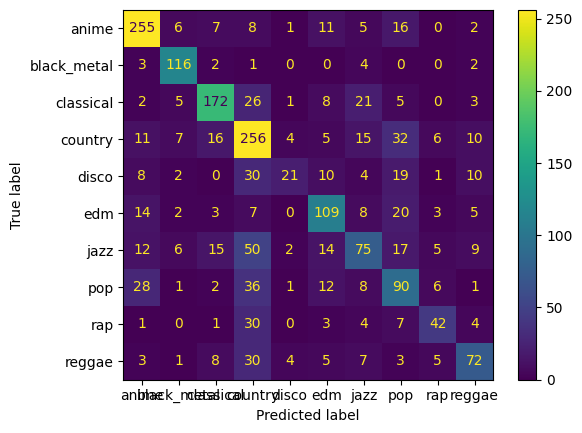

In [44]:
cm_display = ConfusionMatrixDisplay(cm, display_labels = labels)
cm_display.plot();

Мы построили матрицу ошибок, чтобы понять, в каких жанрах наша модель ошибается чаще всего. Как можно заметить, модель часто неверно присваивает обложкам жанр кантри, что неудивительно, таких обложек у нас больше всего. Заметим, что на втором месте по количеству обложек в нашем распоряжении жанри аниме, что этот жанр модель реже ошибочно присваивает другим обложкам

## 7. Наброски для рекомендательной системы

Загрузим в отдельную папку радномные обложки

In [45]:
path = '/Users/ivanpeschinsky/Documents/New/studing/masterskaya_cv/test_test/'

In [46]:
random_image = []
random_image_name = []

for filename in os.listdir(path):
    f = os.path.join(path, filename)
    if os.path.isfile(f):
        random_image.append(Image.open(f).convert('RGB'))
        random_image_name.append(ntpath.basename(f))

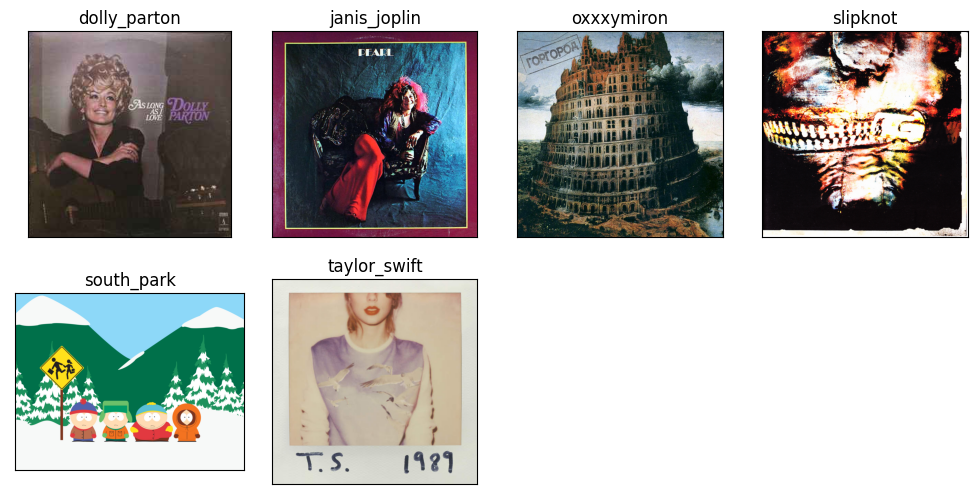

In [47]:
fig = plt.figure(figsize=(10, 10))

for i in range(6):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(random_image[i])
    plt.title(random_image_name[i].split('.')[0])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Мы взяли для проверки шесть изображений:
1) dolly parton - кантри певица
2) janis joplin - рок
3) oxxxymiron - русский рэп
4) slipknot - nu metal
5) south park - обложка мультфильма
6) taylor swift - кантри, поп

In [48]:
random_image_tensor = []

for image in random_image:
    image_tensor = preprocess(image).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    random_image_tensor.append(output_tensor)

In [49]:
random_image_df = pd.DataFrame(random_image_tensor).astype('float')

In [50]:
svc_random_pred = svc_model.predict(random_image_df)

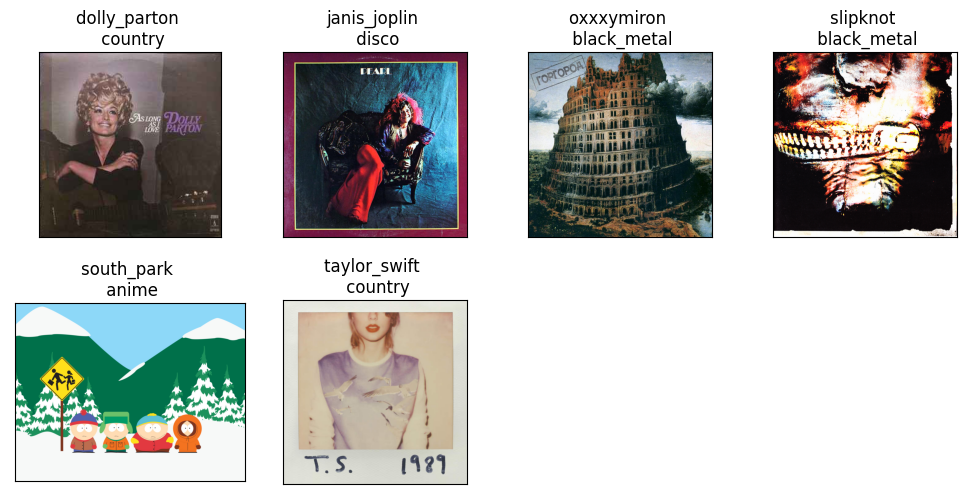

In [51]:
fig = plt.figure(figsize=(10, 10))

for i in range(6):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(random_image[i])
    plt.title(f"{random_image_name[i].split('.')[0]} \n {svc_random_pred[i]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В целом модель неплохо справилась, учитывая тот объем данных и ограниченный набор жанров, на которых она обучалась.
1) dolly parton - точно угадано
2) janis joplin - у нас не было в обучающих данных рока, поэтому тут мимо
3) oxxxymiron - специально выбрали сложную обложку. ожидаемо, ошибка
4) slipknot - это точно металл)
5) south park - animation)
6) taylor swift - попали, тэйлор свифт вполне кантри-поп

## 8 Вариант с fastai

In [52]:
# здесь будет ссылка на гитхаб с проектом на fastai

## 9 Выводы

Наша задача была - разработать модель определения жанра музыкального альбома по изображению его обложки. В нашем распоряжении был набор данных из почти 8000 музыкальных обложек 10 жанров.

Мы выполнили загрузку данных, преобразовали их и собрали из них датасет. Для обучения были выбраны простые и быстрые модели. В качестве метрики использовалась accuracy, т.к. впоследствии, если мы будет разрабатывать рекомендательную систему, для пользователя будет важно, чтобы модель как можно лучше угадывала жанр из всего объема данных.

Самого высокого результата удалось добиться с помощью модели SVC - 0.63. Это неплохой показатель с учетом ограниченного набора данных. Можно сделать вывод, что в целом можно построить рекомендательную систему на основе обложек. 

В дальнейшем модель можно улучшить за счет увеличения количества обложек и жанров. Это определенно усложнит задачу, т.к. разные жанры могут пересекаться или быть частью друг друга.

Мы также попробовали решить задачу инструментами fastai. Модель довольна проста в плане кода, но работает очень медленно. 

В конце мы сделали небольшой набросок будущей рекомендательной системы. Мы взяли несколько рандомных обложек не из датасета и попробовали определить их жанр. Модель неплохо распознала то, что ей уже знакомо, но ошиблась в более сложных или не представленных в датасете жанрах.

Мы даже решили задачу инструментами fast ai. Модель показала такой же результат - 0.63, но на нашей имитации тестовых данных сработала хуже более простого решения.